This uses the <a href="https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv">Pima Indians Diabetes Dataset</a> downloaded from Kaggle.  It contains measurements of 768 women of Pima ancestry.  The target variable is whether or not they had diabetes and the other attributes are health variables.
    
In this notebook, we will attempt to train various machine learning models to predict whether or not the patient has diabetes based on the other attributes given.  The algorithms used will be Logistic Regression, Random Forests, and Neural Networks.  We will use scikit-learn 0.23.2 for Logistic Regression and Random Forests.  For Neural Networks will will use Tensorflow 2.0.0 and Keras 2.3.1.

First, impor the usual suspects.

In [29]:
# dataframes and plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# scikit-learn data splitting and prediction analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# the models used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [48]:
import sklearn
print(sklearn.__version__)
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

0.23.2
2.3.1
2.0.0


In [4]:
diab = pd.read_csv('diabetes.csv')
diab.shape

(768, 9)

In [5]:
diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
diab.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

So in this data set, 500 were not diagnosed as diabetic and 268 were.

Before going furthing, I would like to convert the columns to lowercase names.  I just find it easier to type.

In [7]:
lower_case_columns = []
new_column_names = {}
for column in diab.columns:
    new_column_names[column] = column.lower()
diab = diab.rename(columns = new_column_names)
diab.columns

Index(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin',
       'bmi', 'diabetespedigreefunction', 'age', 'outcome'],
      dtype='object')

Next, I am curious how each one is correlated to the target.

<AxesSubplot:>

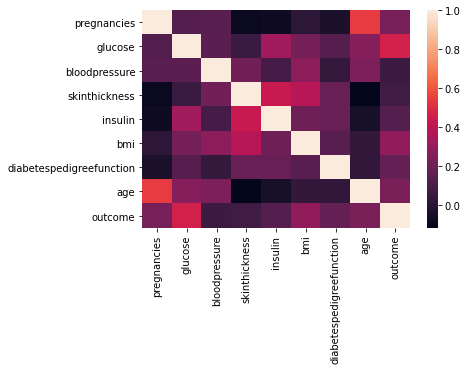

In [8]:
sns.heatmap(diab.corr())

Listing the correlations with the outcome might be clearer.  So let's find the correlation of each variable with the outcome and list them in descending order.

In [9]:
correlations = []
for column in diab.columns[:-1]:
    correlations.append((column,  diab.outcome.corr(diab[column])))
correlations.sort(key = lambda kv: kv[1], reverse=True)
correlations

[('glucose', 0.4665813983068733),
 ('bmi', 0.29269466264444505),
 ('age', 0.23835598302719765),
 ('pregnancies', 0.2218981530339865),
 ('diabetespedigreefunction', 0.17384406565295976),
 ('insulin', 0.13054795488404788),
 ('skinthickness', 0.07475223191831944),
 ('bloodpressure', 0.06506835955033273)]

Before using some algorithms liks logistic regression and neural networks, it often works best to scan the columns, often to between -1 and 1 or 0 and 1.  Another possbility is to scale the values by how many standard deviations they are from the mean.

In [10]:
diab.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


If you look at all the graphs, you will see that most of the variables are not normally distributed, so I won't use the standard deviation methond.  I will simply shrink and stratch each attribute to fit between 0 and 1.

In [11]:
'''
Uncomment to show all the graphs.
for column in list(diab.columns[:-1]):
    if diab[column].dtype == 'int64':
        sns.countplot(diab[column])
    else:
        sns.distplot(diab[column])
    plt.show()
'''

"\nUncomment to show all the graphs.\nfor column in list(diab.columns[:-1]):\n    if diab[column].dtype == 'int64':\n        sns.countplot(diab[column])\n    else:\n        sns.distplot(diab[column])\n    plt.show()\n"

In [12]:
def linear_scale_column(column):
    column = pd.Series(column)  # make sure it is a series so we can do a vectorized operation
    min = column.min()
    max = column.max()
    column = column.apply(lambda n: (n - min) / (max - min))
    return column

In [13]:
for column_name in ['pregnancies',
 'glucose',
 'bloodpressure',
 'skinthickness',
 'insulin',
 'bmi',
 'diabetespedigreefunction',
 'age']:
    diab[column_name] = linear_scale_column(diab[column_name])

In [14]:
diab.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.607510,0.566438,0.207439,0.094326,0.476790,0.168179,0.204015,0.348958
std,0.198210,0.160666,0.158654,0.161134,0.136222,0.117499,0.141473,0.196004,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.497487,0.508197,0.000000,0.000000,0.406855,0.070773,0.050000,0.000000
50%,0.176471,0.587940,0.590164,0.232323,0.036052,0.476900,0.125747,0.133333,0.000000
75%,0.352941,0.704774,0.655738,0.323232,0.150414,0.545455,0.234095,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


So now they are all between 0 and 1.  Interestingly, the correlations are stil the same.

In [15]:
correlations = []
for column in diab.columns[:-1]:
    correlations.append((column,  diab.outcome.corr(diab[column])))
correlations.sort(key = lambda kv: kv[1], reverse=True)
correlations

[('glucose', 0.4665813983068734),
 ('bmi', 0.2926946626444452),
 ('age', 0.23835598302719743),
 ('pregnancies', 0.22189815303398672),
 ('diabetespedigreefunction', 0.17384406565295984),
 ('insulin', 0.1305479548840473),
 ('skinthickness', 0.0747522319183193),
 ('bloodpressure', 0.06506835955033263)]

Now we'll start training algorithms and doing predictions.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(diab[diab.columns[:-1]], diab.outcome, test_size=.3, random_state=37)

In [18]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_predictions = lr.predict(x_test)
print(accuracy_score(y_test, lr_predictions))
print(confusion_matrix(y_test, lr_predictions))

0.7792207792207793
[[141  10]
 [ 41  39]]


In [19]:
pd.Series(y_test).value_counts() / len(y_test)

0    0.65368
1    0.34632
Name: outcome, dtype: float64

In [20]:
pd.Series(lr_predictions).value_counts() / len(lr_predictions)

0    0.787879
1    0.212121
dtype: float64

In [21]:
def do_one_run(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    #return predictions

In [22]:
#lr_predictions = do_one_run(lr, x_train, x_test, y_train, y_test)
do_one_run(lr, x_train, x_test, y_train, y_test)

0.7792207792207793
[[141  10]
 [ 41  39]]


Now try Random Forests.

In [23]:
rf = RandomForestClassifier()
#rf_predictions = do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)

0.7575757575757576
[[134  17]
 [ 39  41]]


But due to the radomness involved, there is some veriability in Random Forests

In [24]:
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)

0.7575757575757576
[[133  18]
 [ 38  42]]
0.7575757575757576
[[131  20]
 [ 36  44]]
0.7792207792207793
[[136  15]
 [ 36  44]]
0.7532467532467533
[[133  18]
 [ 39  41]]
0.7705627705627706
[[132  19]
 [ 34  46]]
0.7489177489177489
[[132  19]
 [ 39  41]]


So let's use the n_estimators parameter to increase the number of trees and see if that gives us more agreement between runs of the program.

In [25]:
'''rf = RandomForestClassifier(n_estimators=700)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)'''

0.7532467532467533
[[132  19]
 [ 38  42]]
0.7575757575757576
[[132  19]
 [ 37  43]]
0.7489177489177489
[[132  19]
 [ 39  41]]
0.7445887445887446
[[131  20]
 [ 39  41]]


In [26]:
rf = RandomForestClassifier(n_estimators=5000)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)
do_one_run(rf, x_train, x_test, y_train, y_test)

0.7532467532467533
[[131  20]
 [ 37  43]]
0.7532467532467533
[[131  20]
 [ 37  43]]
0.7619047619047619
[[132  19]
 [ 36  44]]
0.7445887445887446
[[131  20]
 [ 39  41]]


Let's remind ourselfs what the Logistic Regression result was.  (The results of Logistic Regression are stable from one run to the next).

In [27]:
do_one_run(lr, x_train, x_test, y_train, y_test)

0.7792207792207793
[[141  10]
 [ 41  39]]


So Logistic Regression has a slightly better accuracy score than Random Forest with n_estimators=5000.  In this data set, with this train test split, Random Forests do seem to have a slightly lower number of false negatives (bad) and a slightly higher number of true negatives (bad).

Now let's look at neural networks.

In [30]:
model = Sequential()
model.add(Dense(16, input_dim=8, activation='relu'))
model.add(Dense(16, input_dim=16, activation='relu'))
model.add(Dense(16, input_dim=16, activation='relu'))
model.add(Dense(16, input_dim=16, activation='relu'))
model.add(Dense(16, input_dim=16, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 100
y_binary = to_categorical(y_train)
model.fit(x_train, y_binary, epochs=num_epochs, verbose=0)

dnn_predictions = model.predict(x_test)
y_test_binary = to_categorical(y_test)

pred = np.apply_along_axis(lambda r: 1 if r[1] > r[0] else 0, 1, dnn_predictions)
confusion_matrix(y_test, pred)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))

0.7575757575757576
[[124  27]
 [ 29  51]]


Let's make a function where we can more easily change a few parameters and re run.

In [31]:
def do_one_dnn_run(num_layers, layer_size_ratio, num_epochs = 100):
    model = Sequential()
    layer_width = 8 * layer_size_ratio
    model.add(Dense(layer_width, input_dim=8, activation='relu'))
    for i in range(num_layers - 1):
        model.add(Dense(layer_width, input_dim=layer_width, activation='relu'))
    #model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    y_binary = to_categorical(y_train)
    model.fit(x_train, y_binary, epochs=num_epochs, verbose=0)

    dnn_predictions = model.predict(x_test)
    y_test_binary = to_categorical(y_test)

    pred = np.apply_along_axis(lambda r: 1 if r[1] > r[0] else 0, 1, dnn_predictions)
    print(accuracy_score(y_test, pred))
    print(confusion_matrix(y_test, pred))
    

In [32]:
do_one_dnn_run(5, 2, 100)

0.7402597402597403
[[131  20]
 [ 40  40]]


In [35]:
do_one_dnn_run(5, 2, 100)
do_one_dnn_run(5, 2, 100)
do_one_dnn_run(5, 2, 100)
do_one_dnn_run(5, 2, 100)

0.7748917748917749
[[123  28]
 [ 24  56]]
0.7575757575757576
[[123  28]
 [ 28  52]]
0.7575757575757576
[[129  22]
 [ 34  46]]
0.7705627705627706
[[127  24]
 [ 29  51]]


In [33]:
do_one_dnn_run(10, 2, 100)

0.7316017316017316
[[113  38]
 [ 24  56]]


In [36]:
do_one_dnn_run(10, 2, 100)
do_one_dnn_run(10, 2, 100)
do_one_dnn_run(10, 2, 100)
do_one_dnn_run(10, 2, 100)

0.7878787878787878
[[132  19]
 [ 30  50]]
0.7359307359307359
[[110  41]
 [ 20  60]]
0.7619047619047619
[[121  30]
 [ 25  55]]
0.7619047619047619
[[120  31]
 [ 24  56]]


In [37]:
do_one_dnn_run(5, 4, 100)
do_one_dnn_run(5, 4, 100)
do_one_dnn_run(5, 4, 100)
do_one_dnn_run(5, 4, 100)
do_one_dnn_run(5, 4, 100)

0.70995670995671
[[113  38]
 [ 29  51]]
0.7532467532467533
[[128  23]
 [ 34  46]]
0.7402597402597403
[[121  30]
 [ 30  50]]
0.696969696969697
[[110  41]
 [ 29  51]]
0.7575757575757576
[[124  27]
 [ 29  51]]


In [38]:
do_one_dnn_run(25, 2, 100)
do_one_dnn_run(25, 2, 100)
do_one_dnn_run(25, 2, 100)

0.7316017316017316
[[143   8]
 [ 54  26]]
0.7316017316017316
[[118  33]
 [ 29  51]]
0.7272727272727273
[[103  48]
 [ 15  65]]


In [40]:
do_one_dnn_run(25, 2, 100)
do_one_dnn_run(25, 2, 100)

0.7186147186147186
[[103  48]
 [ 17  63]]
0.7316017316017316
[[120  31]
 [ 31  49]]


In [41]:
do_one_dnn_run(5, 2, 400)
do_one_dnn_run(5, 2, 400)
do_one_dnn_run(5, 2, 400)
do_one_dnn_run(5, 2, 400)

0.7575757575757576
[[126  25]
 [ 31  49]]
0.6796536796536796
[[116  35]
 [ 39  41]]
0.6753246753246753
[[111  40]
 [ 35  45]]
0.7402597402597403
[[119  32]
 [ 28  52]]


It is quite possible that I am not setting up the network correctly or tuning the parameters properly.  However, so far I am not seeing anything about the neural network runs that seems to give it an advantage over logistic regression.  A few of the neural network runs have had a slightly higher accuracy score, but most do not.  Increasing the number of layers or the number of neurons in a layer does not seem to be working.

For further research:

    -More experimenting with Neural Networks.  I am still someone new to it.
    -Experiment with parameter tuning on Random Forests.
    -Train with different train/test splits.
    -Functions that run multiple runs of an algorithm and aggregate the results.
    -principal component analysis.
    

Conclusion:
    
In this dataset, using a Logistic Regression model with scikit-learn, we can predict whether or not a woman was diagnosed with diabetes, based on the other variables given, with about 77.9% accuracy.  Logistic Regression is slightly more accurate than Random Forest, and more accurate than most of the attemps with Neural Networks.